
# Belief Propagation (BP): Exact on Trees, Approximate on Loopy Graphs

This notebook accompanies the **Belief Propagation (BP)** subsection.

We compare:
- a **tree** Ising model (BP should be exact)
- a **loopy** Ising model on the same nodes (BP is approximate)

We visualize:
- convergence behavior (message residual vs iteration)
- marginal accuracy vs exact enumeration (n=12 → 4096 states)


In [1]:

import os
import numpy as np
import matplotlib.pyplot as plt
import itertools

os.makedirs("figs", exist_ok=True)
np.random.seed(1)


In [2]:

n = 12

def random_tree_edges(n, rng):
    edges=[]
    for i in range(1,n):
        j = int(rng.integers(0,i))
        edges.append((j,i))
    return [tuple(sorted(e)) for e in edges]

tree_edges = random_tree_edges(n, np.random.default_rng(2))

def add_loops(edges, extra, rng):
    E=set(edges)
    while len(E) < len(edges)+extra:
        i = int(rng.integers(0,n))
        j = int(rng.integers(0,n))
        if i==j:
            continue
        a,b = (i,j) if i<j else (j,i)
        if (a,b) not in E:
            E.add((a,b))
    return sorted(E)

loopy_edges = add_loops(tree_edges, extra=4, rng=np.random.default_rng(4))

def energy(x, edges, J, h):
    e=0.0
    for i,j in edges:
        e -= J*x[i]*x[j]
    e -= np.dot(h, x)
    return e

def exact_marginals(edges, J, h):
    Z=0.0
    m=np.zeros(n)
    for bits in itertools.product([-1,1], repeat=n):
        x=np.array(bits, dtype=float)
        w=np.exp(-energy(x, edges, J, h))
        Z += w
        m += w*x
    m /= Z
    return m

def bp_pairwise_ising(edges, J, h, iters=200, damping=0.35):
    nbr=[[] for _ in range(n)]
    for i,j in edges:
        nbr[i].append(j); nbr[j].append(i)
    dirs=[]
    for i,j in edges:
        dirs.append((i,j)); dirs.append((j,i))
    msg = {(i,j): np.ones(2) for (i,j) in dirs}  # [to -1, to +1]

    residual=[]
    for _ in range(iters):
        maxdiff=0.0
        newmsg={}
        for (i,j) in dirs:
            prod_minus=1.0
            prod_plus=1.0
            for k in nbr[i]:
                if k==j:
                    continue
                mk = msg[(k,i)]
                prod_minus *= mk[0]
                prod_plus  *= mk[1]

            w_minus = np.exp(-h[i]) * prod_minus
            w_plus  = np.exp(+h[i]) * prod_plus

            m_to_minus = np.exp(+J)*w_minus + np.exp(-J)*w_plus
            m_to_plus  = np.exp(-J)*w_minus + np.exp(+J)*w_plus

            mvec=np.array([m_to_minus, m_to_plus], dtype=float)
            mvec /= mvec.sum()

            mvec = (1-damping)*msg[(i,j)] + damping*mvec
            newmsg[(i,j)] = mvec
            maxdiff = max(maxdiff, np.max(np.abs(mvec - msg[(i,j)])))
        msg = newmsg
        residual.append(maxdiff)

    marg=np.zeros(n)
    for i in range(n):
        prod_minus=1.0; prod_plus=1.0
        for k in nbr[i]:
            mk=msg[(k,i)]
            prod_minus *= mk[0]
            prod_plus  *= mk[1]
        q_minus = np.exp(-h[i])*prod_minus
        q_plus  = np.exp(+h[i])*prod_plus
        Z = q_minus+q_plus
        p_plus = q_plus/Z
        marg[i] = (+1)*p_plus + (-1)*(1-p_plus)
    return marg, np.array(residual)


In [3]:

J=0.45
h = 0.15*np.random.randn(n)

m_tree_exact = exact_marginals(tree_edges, J, h)
m_loop_exact = exact_marginals(loopy_edges, J, h)

m_tree_bp, res_tree = bp_pairwise_ising(tree_edges, J, h, iters=200, damping=0.35)
m_loop_bp, res_loop = bp_pairwise_ising(loopy_edges, J, h, iters=200, damping=0.35)

err_tree = np.mean(np.abs(m_tree_exact - m_tree_bp))
err_loop = np.mean(np.abs(m_loop_exact - m_loop_bp))

print("Mean |m_exact - m_BP|  tree =", err_tree)
print("Mean |m_exact - m_BP| loopy =", err_loop)


Mean |m_exact - m_BP|  tree = 6.909981845974281e-16
Mean |m_exact - m_BP| loopy = 0.015572827671385417


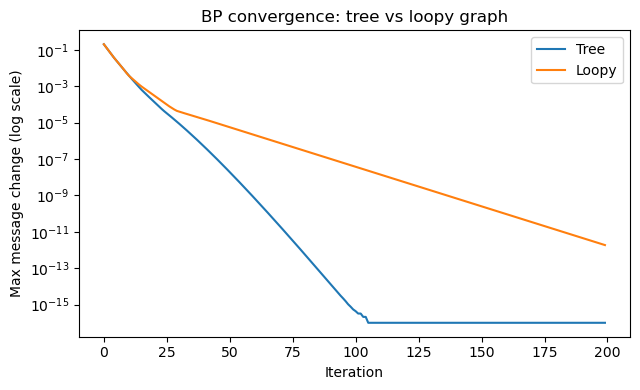

In [4]:

plt.figure(figsize=(6.5,4))
plt.semilogy(res_tree + 1e-16, label="Tree")
plt.semilogy(res_loop + 1e-16, label="Loopy")
plt.xlabel("Iteration")
plt.ylabel("Max message change (log scale)")
plt.title("BP convergence: tree vs loopy graph")
plt.legend()
plt.tight_layout()
plt.savefig("figs/bp_convergence_tree_vs_loopy.png", dpi=150)
plt.show()


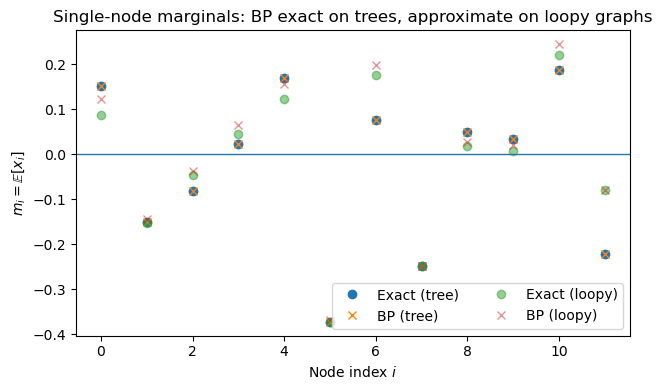

In [5]:

plt.figure(figsize=(6.5,4))
plt.plot(m_tree_exact, "o", label="Exact (tree)")
plt.plot(m_tree_bp, "x", label="BP (tree)")
plt.plot(m_loop_exact, "o", alpha=0.5, label="Exact (loopy)")
plt.plot(m_loop_bp, "x", alpha=0.5, label="BP (loopy)")
plt.axhline(0, linewidth=1)
plt.xlabel("Node index $i$")
plt.ylabel(r"$m_i=\mathbb{E}[x_i]$")
plt.title("Single-node marginals: BP exact on trees, approximate on loopy graphs")
plt.legend(ncol=2)
plt.tight_layout()
plt.savefig("figs/bp_marginals_tree_vs_loopy.png", dpi=150)
plt.show()


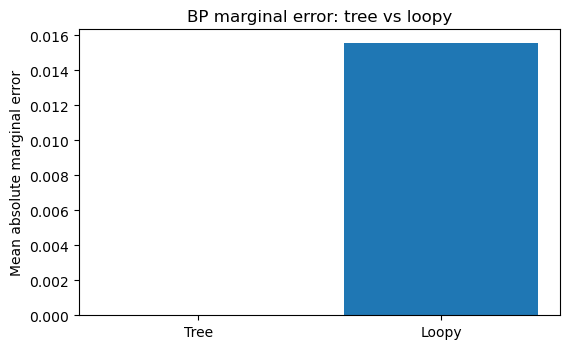

In [6]:

plt.figure(figsize=(5.8,3.6))
plt.bar(["Tree","Loopy"], [err_tree, err_loop])
plt.ylabel("Mean absolute marginal error")
plt.title("BP marginal error: tree vs loopy")
plt.tight_layout()
plt.savefig("figs/bp_marginal_error_bar.png", dpi=150)
plt.show()



**Interpretation.**
- On a **tree**, BP matches exact marginals (up to numerical tolerance).
- On a **loopy** graph, BP is generally approximate; convergence and accuracy depend on
  coupling strength, loop structure, and damping.
